In [441]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy

import numpy as np
from sklearn import preprocessing

In [442]:
# https://www.rug.nl/ggdc/historicaldevelopment/maddison/releases/maddison-project-database-2020
df_gdp = pd.read_csv('gdp_2016.csv', delimiter=';')
df_gdp = df_gdp.rename(columns={'Country': 'CountryName'})
df_gdp = df_gdp.drop(['Abbreviation', 'Year'], axis=1)
# GDP read as object
df_gdp['GDP'] = df_gdp['GDP'].astype(str).astype(float)
# list(df_gdp.columns)

In [443]:
# https://www.kaggle.com/datasets/georgeam/european-agriculture-indicatorseurostat-2016
df_farms = pd.read_csv('EuropeanAgriculture_FarmStructureIndicators_Eurostat2016.csv')

# Woah this looks different
This is a Jupyter Notebook. It's commonly used in Data Analysis because it lets you test, document, and present code sucinctly. You can basically build a website with your code that's easy to understand and edit

Most of the code is hidden, because you're probably here for analysis and graphs. If you want to see the code, [check out the full repository, here.](https://github.com/mosesju/MapExerciseFarm)
## WTF is this data?
- This is data sourced from Eurostat, and explores differences between the Agricultural Sectors across European countries
- The database contains a selection of Farm Structure Indicators for EU member states (28 countries, including UK). The selected indicators provide an overview of the European Agricultural sector (for a non-expert public) and allow for relevant comparisons between EU countries. It covers the year 2016
- Simple and high level overview of the structure of the European farming system
- Last week, [I wrote about the EU Green Deal](https://farmerju.beehiiv.com/p/eu-green-deal-and-its-impact-on-agriculture?utm_source=linkedin.com&utm_medium=referral&utm_campaign=map_exercise). This looked at the structure of the green deal, which is heavily influenced by CAP. To further this, I needed to understand how farms are distributed across europe. While some data is missing, this is an awesome way to get a better understanding of the EU farming system

In [444]:
# forgot where I sleuthed this from. Just to put points on the map
df_coords = pd.read_csv('country-capitals.csv',on_bad_lines='skip')

In [445]:
df = pd.merge(
    df_farms, 
    df_coords, 
    how="left", 
    left_on="Country", 
    right_on="CountryName"
)
df = df.drop(['CountryName','ContinentName'], axis=1)

In [446]:
df = pd.merge(
    df, 
    df_gdp, 
    how="left", 
    left_on="Country", 
    right_on="CountryName"
)
df = df.drop(['CountryName'], axis=1)
df.head()

,Country,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,...,farms_SO_25000-49999,farms_SO_50000-99999,farms_SO_100000-249999,farms_SO_250000-499999,farms_SO_500000_orover,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,GDP
0,Belgium,36890,1354250,8.037986e+09,NaN,70910,55350,19800.0,14810.0,9940,...,4310,5130,9010,7170,3880,Brussels,50.833333,4.333333,BE,4.393590e+11
1,Bulgaria,202720,4468500,3.842891e+09,0.0,439740,255520,64490.0,59100.0,5360,...,6780,4040,2740,1480,1510,Sofia,42.683333,23.316667,BG,1.238846e+11
2,Czechia,26530,3455410,NaN,4120.0,130290,103270,81840.0,71440.0,4910,...,3200,2400,2230,980,1930,NaN,NaN,NaN,NaN,3.038507e+11
3,Denmark,35050,2614600,1.006244e+10,0.0,73320,49480,25780.0,22840.0,16340,...,5510,4260,3910,2170,5510,Copenhagen,55.666667,12.583333,DK,2.568218e+11
4,Germany,276120,16715320,4.924902e+10,0.0,653760,502610,178640.0,148330.0,133520,...,37200,40100,53820,32350,20430,Berlin,52.516667,13.400000,DE,3.735419e+12


In [447]:
# plt.figure(figsize=(10,40))
# for x in (range(1,30)):
#     plt.subplot(19,1,x)
#     sns.boxplot(x =  df.columns[x-1], data=df)
#     x_name = df.columns[x-1]
#     plt.title(f'Distribution of {x_name}')         
# plt.tight_layout()

## Looking at data (above)
- What columns are correlated
    - Make a heat map to see what's up
- Could be interesting to see how the distribution of farms changes using the farm_SO_(value) columns
    - A stacked bar graph could give. a quick check of what is actually happening in each nation as far as income distribution goes
    - Done
- Take a closer look at subsistence farms
    - How do these correlate with GDP
- How do all of these metrics correlate with agricultural output?
    - More subsistence farms higher or lower output => what nuance is this missing?
- How does manager training impact output at a country level?
    - Need more context as to what the training actually means?
- Plot laborers per farm and per ha on a map
    - What countries are using their resources most effectively

## Scale Columns
- Normalizes the data so it's easier for me to scale variables
- Makes it easier to compare similar data points for the chart

In [448]:
df["labor_per_ha"] = df["total_labour_persons"]/df["used_agricultural_area_ha"]

In [449]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        new_col_name = col+'_normalized'
        df[new_col_name] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col]) * 1000
    return df

In [450]:
# did this so it would be easier to put on a map. and scaling wouldn't be an issue
min_max_scaler = preprocessing.MinMaxScaler()
df = scaleColumns(df, ['farms_number','used_agricultural_area_ha','standard_output_EUR', 'managers_full_training', 'GDP'])

/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
posx and posy should be finite values
posx and posy should

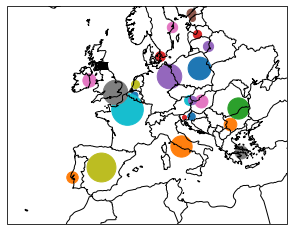

In [451]:
central_lon, central_lat = -5, 55
extent = [-20, 30, 30, 60]

plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))

# print(df['CapitalLongitude'], df['CapitalLatitude'])
cmap = plt.cm.rainbow

for i in df.itertuples():
    plt.text(i.CapitalLongitude, i.CapitalLatitude, i.CountryCode)
    ax.scatter(
        i.CapitalLongitude, 
        i.CapitalLatitude, 
        s=i.used_agricultural_area_ha_normalized,
        # s=i.farms_number_normalized,
        # color='blue', 
        # color = cmap(i.used_agricultural_area_ha_normalized),
        # color = cmap(i.farms_number_normalized),
        transform=ccrs.PlateCarree()
    )

ax.set_extent(extent)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)

plt.show()
# plt.savefig('used_agricultural_area_ha_normalized')

## What do we see
- This map shows how farmland is distributed across Europe
    - Data is normalized so it's relative
- Would be interesting to see how much labor / ha there is and how efficient more vs. less labor is
- France Spain and Germany have the most agricultural land, and are in the top 4 in output
    - The only "outlier" here is Italy, has the 6th most land, but is second in standard output
## The data below
The tables below show the 5 largest nations for agricultural area used, and standard output

In [452]:
df.nlargest(5, ['used_agricultural_area_ha'])

,Country,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,...,CapitalLatitude,CapitalLongitude,CountryCode,GDP,labor_per_ha,farms_number_normalized,used_agricultural_area_ha_normalized,standard_output_EUR_normalized,managers_full_training_normalized,GDP_normalized
9,France,456520,27814160,6.134314e+10,7040.0,859750,708170,403750.0,334590.0,129340,...,48.866667,2.333333,FR,2.479390e+12,0.030911,132.907025,1000.000000,1000.000000,411.626405,662.518154
8,Spain,945020,23229750,3.836561e+10,33400.0,1866210,822370,351200.0,188590.0,186720,...,40.400000,-3.683333,ES,1.417044e+12,0.080337,275.740776,835.111196,624.826715,44.774577,377.077036
4,Germany,276120,16715320,4.924902e+10,0.0,653760,502610,178640.0,148330.0,133520,...,52.516667,13.400000,DE,3.735419e+12,0.039111,80.159412,600.804804,802.529283,121.017956,1000.000000
27,United Kingdom,185060,16673270,2.540345e+10,NaN,426610,284940,99540.0,61440.0,26210,...,51.500000,-0.083333,GB,2.460057e+12,0.025586,53.534149,599.292380,413.182793,81.927400,657.323689
20,Poland,1410700,14405650,2.500564e+10,259000.0,3088250,1649400,122480.0,109640.0,244120,...,52.250000,21.000000,PL,9.529368e+11,0.214378,411.902130,517.732234,406.687387,1000.000000,252.376232


In [453]:
df.nlargest(5, ['standard_output_EUR'])

,Country,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,...,CapitalLatitude,CapitalLongitude,CountryCode,GDP,labor_per_ha,farms_number_normalized,used_agricultural_area_ha_normalized,standard_output_EUR_normalized,managers_full_training_normalized,GDP_normalized
9,France,456520,27814160,6.134314e+10,7040.0,859750,708170,403750.0,334590.0,129340,...,48.866667,2.333333,FR,2.479390e+12,0.030911,132.907025,1000.000000,1000.000000,411.626405,662.518154
11,Italy,1145710,12598160,5.168902e+10,289880.0,2045410,897090,231730.0,111180.0,1048150,...,41.900000,12.483333,IT,2.026955e+12,0.162358,334.421034,452.721717,842.369252,179.098308,540.953660
4,Germany,276120,16715320,4.924902e+10,0.0,653760,502610,178640.0,148330.0,133520,...,52.516667,13.400000,DE,3.735419e+12,0.039111,80.159412,600.804804,802.529283,121.017956,1000.000000
8,Spain,945020,23229750,3.836561e+10,33400.0,1866210,822370,351200.0,188590.0,186720,...,40.400000,-3.683333,ES,1.417044e+12,0.080337,275.740776,835.111196,624.826715,44.774577,377.077036
27,United Kingdom,185060,16673270,2.540345e+10,NaN,426610,284940,99540.0,61440.0,26210,...,51.500000,-0.083333,GB,2.460057e+12,0.025586,53.534149,599.292380,413.182793,81.927400,657.323689


## The Map
This map shows us how much agricultural land various countries across europe have. We see that France, Spain and Germany have the most agricultural land. We see that they also have the highest standard outputs. This is corroborated with the correlation we do later

<AxesSubplot:xlabel='CountryCode'>

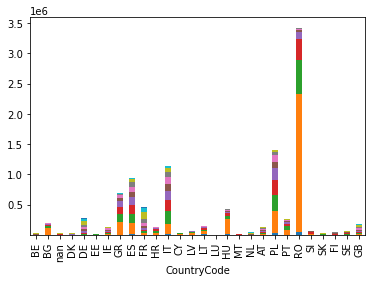

In [454]:
df_stacked = df[[
    'CountryCode',
    'farms_SO_zero',
    'farms_SO_less2000',
    'farms_SO_2000-3999',
    'farms_SO_4000-7999',
    'farms_SO_8000-14999',
    'farms_SO_15000-24999',
    'farms_SO_25000-49999',
    'farms_SO_50000-99999',
    'farms_SO_100000-249999',
    'farms_SO_250000-499999',
    'farms_SO_500000_orover'
    ]].copy()
df_stacked = df_stacked.set_index('CountryCode')
df_stacked.plot(kind='bar', stacked=True, legend=False)

## What does this show us?
- The vast majority of european farmers are Romanians that have an output of less than 4.000 euros
    - Culture of [Romanian Family Farms](https://paperzz.com/doc/8600894/family-farming-in-romania)
- When combined with the heat back below, we see that smaller farms correlate with:
    - More farms across the country
    - More subsistence farms (farmers sell less than 50% of what they grow)
    - More laborers
    - Less Standard Output
    - Less training
- Standard Output is
    - average monetary value of the agricultural output at farm-gate price, in euro per hectare or per head of livestock.
- What is the output / acre on these smaller farms?
    - The number of smaller farms and the labor / ha in a country aren't well coordinated

In [455]:
# Correlation matrix 
df_corrs = df.corr()
df_corrs.style.background_gradient() #cmap ='plasma')

,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,managers_only_practical,managers_full_training,managers_training_NA,farms_SO_zero,farms_SO_less2000,farms_SO_2000-3999,farms_SO_4000-7999,farms_SO_8000-14999,farms_SO_15000-24999,farms_SO_25000-49999,farms_SO_50000-99999,farms_SO_100000-249999,farms_SO_250000-499999,farms_SO_500000_orover,CapitalLatitude,CapitalLongitude,GDP,labor_per_ha,farms_number_normalized,used_agricultural_area_ha_normalized,standard_output_EUR_normalized,managers_full_training_normalized,GDP_normalized
farms_number,1.000000,0.462026,0.294105,0.905563,0.996108,0.897310,0.310110,0.267903,0.369668,0.942832,0.320447,0.439385,0.962286,0.933195,0.990274,0.951567,0.748964,0.581103,0.484250,0.373291,0.205920,0.101946,0.105764,-0.232279,0.149114,0.155064,0.150684,1.000000,0.462026,0.294105,0.320447,0.155064
used_agricultural_area_ha,0.462026,1.000000,0.880165,0.202818,0.486960,0.670135,0.914926,0.896889,0.390086,0.324724,0.499511,0.327639,0.366382,0.239697,0.385818,0.478039,0.587071,0.632954,0.698165,0.823785,0.872019,0.816960,0.773704,-0.079948,-0.347414,0.805958,-0.204033,0.462026,1.000000,0.880165,0.499511,0.805958
standard_output_EUR,0.294105,0.880165,1.000000,0.013111,0.314756,0.531509,0.890522,0.864075,0.606705,0.079229,0.443583,0.152832,0.155028,0.038801,0.226586,0.333809,0.514233,0.624805,0.727113,0.890253,0.945841,0.914404,0.936642,-0.049343,-0.366091,0.902156,-0.234626,0.294105,0.880165,1.000000,0.443583,0.902156
subsistence_semisubsistence_farms,0.905563,0.202818,0.013111,1.000000,0.878166,0.651560,0.010859,0.002853,0.099873,0.954061,0.014830,0.415704,0.888534,0.992154,0.885381,0.748283,0.397000,0.177781,0.067782,-0.010083,-0.057536,-0.077486,-0.083605,-0.132671,0.208363,-0.043273,0.196148,0.905563,0.202818,0.013111,0.014830,-0.043273
total_labour_persons,0.996108,0.486960,0.314756,0.878166,1.000000,0.926817,0.329050,0.290775,0.374571,0.929003,0.387675,0.421572,0.963035,0.911749,0.989347,0.964898,0.781925,0.618998,0.524236,0.404874,0.220188,0.112777,0.120484,-0.224591,0.135150,0.177192,0.138171,0.996108,0.486960,0.314756,0.387675,0.177192
total_labour_AWU,0.897310,0.670135,0.531509,0.651560,0.926817,1.000000,0.530014,0.512789,0.484231,0.753758,0.661370,0.257514,0.866147,0.708428,0.890800,0.941288,0.893242,0.796713,0.743139,0.640090,0.440819,0.319787,0.312979,-0.187887,0.029171,0.376588,0.039308,0.897310,0.670135,0.531509,0.661370,0.376588
nonfamily_labour_persons,0.310110,0.914926,0.890522,0.010859,0.329050,0.530014,1.000000,0.960753,0.485571,0.141600,0.381251,0.296757,0.191449,0.072857,0.241020,0.346565,0.508870,0.594850,0.683433,0.853363,0.914403,0.829535,0.764851,-0.258138,-0.377877,0.708247,-0.162058,0.310110,0.914926,0.890522,0.381251,0.708247
nonfamily_labour_AWU,0.267903,0.896889,0.864075,0.002853,0.290775,0.512789,0.960753,1.000000,0.341899,0.130810,0.461606,0.166190,0.166251,0.067063,0.187890,0.272503,0.403339,0.479599,0.577336,0.763852,0.907693,0.877913,0.758621,-0.187108,-0.320870,0.702391,-0.171532,0.267903,0.896889,0.864075,0.461606,0.702391
managers_basic_training,0.369668,0.390086,0.606705,0.099873,0.374571,0.484231,0.485571,0.341899,1.000000,0.056307,0.309162,-0.043452,0.268069,0.102444,0.399848,0.500856,0.664389,0.744329,0.777517,0.771003,0.537025,0.334588,0.415447,-0.219408,-0.106785,0.432335,-0.038750,0.369668,0.390086,0.606705,0.309162,0.432335
managers_only_practical,0.942832,0.324724,0.079229,0.954061,0.929003,0.753758,0.141600,0.130810,0.056307,1.000000,0.135635,0.490757,0.924405,0.981491,0.920755,0.830707,0.539925,0.328230,0.208068,0.097753,0.005427,-0.034835,-0.045170,-0.199458,0.196236,-0.004794,0.185954,0.942832,0.324724,0.079229,0.135635,-0.004794


## Observations
#### - GDP 
    - Initially I didn't include GDP in the analysis. It seemed like it would make a pretty big impact, but when you actually look at the numbers it's a leading indicator
    - correlates well with used agricultural land, and standard output
        - the higher your gdp the more land you might have and the higher your standard output would be
        - I wonder if this changes if you calculate yield (output / landmass)
    - I did expect GDP to be more tightly correlated with management practical (expected negative). Pretty much random with a correlation coefficient of -0.004794
    - Did have a stronger correlation to basic training, but not enough to amke a large impact
    - Can see a clear correlation between GDP and the increasing standard output of a farm 
        - Will be interesting when we plot that
        
#### - Larger farms (SO < 100.000)
    - Correlated with higher standard outputs
    - more non family labour
    - less practical only managers
    - higher GDP

In [456]:
df_corrs_standard_output = df_corrs[['farms_SO_zero',
    'farms_SO_less2000',
    'farms_SO_2000-3999',
    'farms_SO_4000-7999',
    'farms_SO_8000-14999',
    'farms_SO_15000-24999',
    'farms_SO_25000-49999',
    'farms_SO_50000-99999',
    'farms_SO_100000-249999',
    'farms_SO_250000-499999',
    'farms_SO_500000_orover'
]]

In [457]:
df_corrs_standard_output = df_corrs_standard_output.rename(columns={
    'farms_SO_zero':'0',
    'farms_SO_less2000': '<2k',
    'farms_SO_2000-3999': '2=>4',
    'farms_SO_4000-7999': '4=>8',
    'farms_SO_8000-14999': '8=>15',
    'farms_SO_15000-24999': '15=>25',
    'farms_SO_25000-49999': '25=>50',
    'farms_SO_50000-99999': '50=>100',
    'farms_SO_100000-249999': '100=>250',
    'farms_SO_250000-499999': '250=>500',
    'farms_SO_500000_orover': '500+'
})
df_corrs_standard_output=df_corrs_standard_output.transpose()

In [458]:
def drop_cols_for_corrs(df):
    return df.drop(columns = [
        'farms_SO_zero',
        'farms_SO_less2000',
        'farms_SO_2000-3999',
        'farms_SO_4000-7999',
        'farms_SO_8000-14999',
        'farms_SO_15000-24999',
        'farms_SO_25000-49999',
        'farms_SO_50000-99999',
        'farms_SO_100000-249999',
        'farms_SO_250000-499999',
        'farms_SO_500000_orover',
        'CapitalLatitude',
        'CapitalLongitude',
        'farms_number_normalized',
        'used_agricultural_area_ha_normalized',
        'standard_output_EUR_normalized'
    ])

In [459]:
df_corrs_standard_output = drop_cols_for_corrs(df_corrs_standard_output)
# df_corrs_standard_output = df_corrs_standard_output.transpose()

df_corrs_standard_output.head()

,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,managers_only_practical,managers_full_training,managers_training_NA,GDP,labor_per_ha,managers_full_training_normalized,GDP_normalized
0,0.962286,0.366382,0.155028,0.888534,0.963035,0.866147,0.191449,0.166251,0.268069,0.924405,0.357771,0.397908,0.031983,0.132719,0.357771,0.031983
<2k,0.933195,0.239697,0.038801,0.992154,0.911749,0.708428,0.072857,0.067063,0.102444,0.981491,0.082218,0.448614,-0.042219,0.207966,0.082218,-0.042219
2=>4,0.990274,0.385818,0.226586,0.885381,0.989347,0.890800,0.241020,0.187890,0.399848,0.920755,0.337640,0.364980,0.079647,0.171287,0.337640,0.079647
4=>8,0.951567,0.478039,0.333809,0.748283,0.964898,0.941288,0.346565,0.272503,0.500856,0.830707,0.472009,0.322099,0.165621,0.128816,0.472009,0.165621
8=>15,0.748964,0.587071,0.514233,0.397000,0.781925,0.893242,0.508870,0.403339,0.664389,0.539925,0.618670,0.167840,0.328829,0.022996,0.618670,0.328829


<AxesSubplot:title={'center':'Correlation vs. Standard Output'}, xlabel='Standard Output', ylabel='Correlation coefficient'>

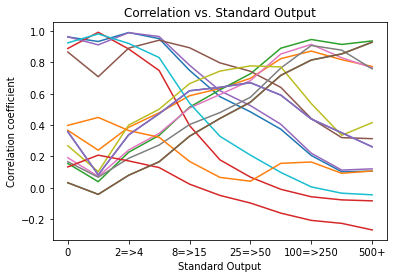

In [460]:
df_corrs_standard_output.plot(
    legend=False,
    title="Correlation vs. Standard Output",
    xlabel="Standard Output",
    ylabel="Correlation coefficient"
)

## What are all these lines?
- These are the correlations between farm output and the various 

<AxesSubplot:title={'center':'Correlation vs. Standard Output'}, xlabel='Standard Output', ylabel='Correlation coefficient'>

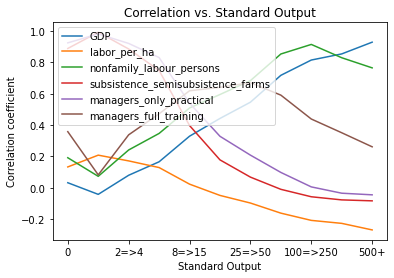

In [461]:
# list(df_corrs_standard_output.columns)
df_corrs_SO_reduced = df_corrs_standard_output[[
    'GDP',
    'labor_per_ha',
    'nonfamily_labour_persons',
    'subsistence_semisubsistence_farms',
    'managers_only_practical',
    'managers_full_training'
]]
df_corrs_SO_reduced.plot(
    legend=True,
    title="Correlation vs. Standard Output",
    xlabel="Standard Output",
    ylabel="Correlation coefficient"
)

## How can we read this?
- There are clear factors that make a difference when it comes to the euro output of a farm.
- If a line goes up and to the right, it means that as this improves euro output should improve as well
- If a line goes down and to the right, it means that as this value lowers the euro output should improve
- Extreme values are better. A correlation that goes from 0=> is stronger than one that goes from -.01=>.01

## What can we learn?
- We see that at the lower ends, farm managers have practical experience, 
- As the farms output increases, they get more eficient in terms of labour
    - bigger farms are more automated than smaller ones, and can take advantage of economies of scale
    - However, the teams are still larger. Just smaller on a per hectare basis
- Nations with higher GDPs have farms with a larger standard output
    - pretty high correlation 0.90215
- Training
    - Once you get to a certain size, managers training doesn't really matter anymore. We see this more clearly in the graph above when we track managers_full_training
    - This manager training data could require standardization.
        - Because there are so few large farms compared to small farms, numbers are probably skewed
    - Manager training matters up to a point, where the data becomes muddied
- The more farms there are the lower the average standard output
    - If there are more farms, we can expect less higher achieving farms
    - Don't ever get to economies of scale
- More subsistence farms indicates lower levels of output
    - subsistence farms have a correlcation of 0.954061 with managers only having practical training
    - Tight correlation with farm size, and standard output
- Less labour is consistent with higher output
    - more efficient use of resources
    - correlates tightly with number of farms. Economies of scale question, again

<AxesSubplot:title={'center':'Correlation vs. Standard Output'}, xlabel='Standard Output', ylabel='Correlation coefficient'>

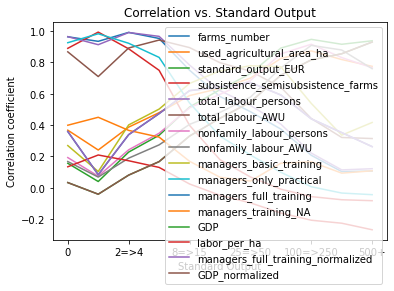

In [462]:
# Use this for the legend
df_corrs_standard_output.plot(
    legend=True,
    title="Correlation vs. Standard Output",
    xlabel="Standard Output",
    ylabel="Correlation coefficient"
)

In [463]:
df_corrs_standard_output.style.background_gradient(cmap ='plasma')

,farms_number,used_agricultural_area_ha,standard_output_EUR,subsistence_semisubsistence_farms,total_labour_persons,total_labour_AWU,nonfamily_labour_persons,nonfamily_labour_AWU,managers_basic_training,managers_only_practical,managers_full_training,managers_training_NA,GDP,labor_per_ha,managers_full_training_normalized,GDP_normalized
0,0.962286,0.366382,0.155028,0.888534,0.963035,0.866147,0.191449,0.166251,0.268069,0.924405,0.357771,0.397908,0.031983,0.132719,0.357771,0.031983
<2k,0.933195,0.239697,0.038801,0.992154,0.911749,0.708428,0.072857,0.067063,0.102444,0.981491,0.082218,0.448614,-0.042219,0.207966,0.082218,-0.042219
2=>4,0.990274,0.385818,0.226586,0.885381,0.989347,0.890800,0.241020,0.187890,0.399848,0.920755,0.337640,0.364980,0.079647,0.171287,0.337640,0.079647
4=>8,0.951567,0.478039,0.333809,0.748283,0.964898,0.941288,0.346565,0.272503,0.500856,0.830707,0.472009,0.322099,0.165621,0.128816,0.472009,0.165621
8=>15,0.748964,0.587071,0.514233,0.397000,0.781925,0.893242,0.508870,0.403339,0.664389,0.539925,0.618670,0.167840,0.328829,0.022996,0.618670,0.328829
15=>25,0.581103,0.632954,0.624805,0.177781,0.618998,0.796713,0.594850,0.479599,0.744329,0.328230,0.640703,0.066121,0.442166,-0.048957,0.640703,0.442166
25=>50,0.484250,0.698165,0.727113,0.067782,0.524236,0.743139,0.683433,0.577336,0.777517,0.208068,0.670403,0.041570,0.545832,-0.097530,0.670403,0.545832
50=>100,0.373291,0.823785,0.890253,-0.010083,0.404874,0.640090,0.853363,0.763852,0.771003,0.097753,0.590927,0.155789,0.717278,-0.162075,0.590927,0.717278
100=>250,0.205920,0.872019,0.945841,-0.057536,0.220188,0.440819,0.914403,0.907693,0.537025,0.005427,0.438514,0.164298,0.814801,-0.208260,0.438514,0.814801
250=>500,0.101946,0.816960,0.914404,-0.077486,0.112777,0.319787,0.829535,0.877913,0.334588,-0.034835,0.350871,0.092163,0.853898,-0.227287,0.350871,0.853898


## Findings from heat map
- Can see a clear trend between standard output and farm size. 
    - As the bands move more towards yellow, the correlation gets stronger. Purple means weaker. Weak correlations mean we can't really find a relationship between the variables
- see the makings of a trend in labor / ha
- Again see that smaller farms tend to have more practical only manager training
    - I think I need farm level data and standardization to clearly make this claim

<AxesSubplot:title={'center':'% of Subsistence Farms of Total Farms'}, ylabel='Country'>

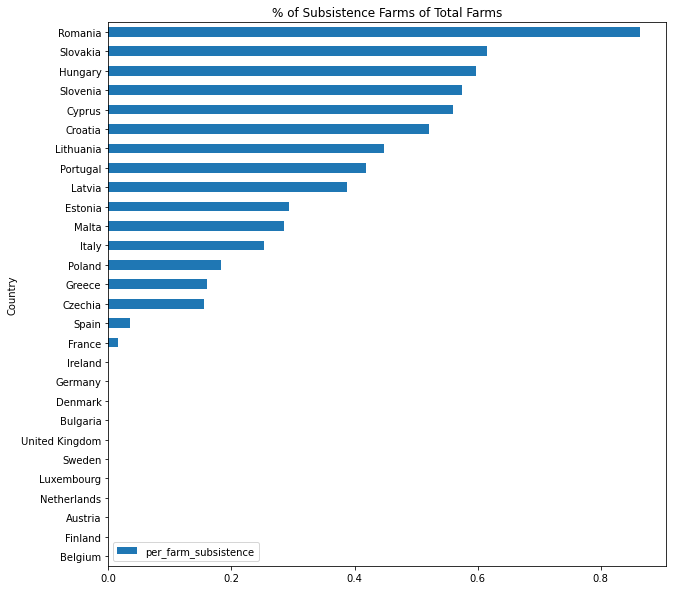

In [464]:
df_sub_farm = df.copy()

df_sub_farm["per_farm_subsistence"] = df_sub_farm.subsistence_semisubsistence_farms / df_sub_farm.farms_number
df_sub_farm["per_farm_subsistence"] = df_sub_farm["per_farm_subsistence"].fillna(0)
# df_sub_farm_trim = df_sub_farm["per_farm_subsistence", "GDP"]
# df_sub_farm["per_farm_subsistence"].dropna()
# df_sub_farm = df_sub_farm["per_farm_subsistence"].fillna(0)
df_sub_farm = df_sub_farm.sort_values(by='per_farm_subsistence')
f, ax = plt.subplots(figsize=(10, 10))
df_sub_farm.plot(ax = ax, x = "Country", y = "per_farm_subsistence", 
        kind = "barh", title = "% of Subsistence Farms of Total Farms")

## What does this show?
- Shows what % of subsistence farms (consume 50% or more of their output) 
- Weird suspicion that Bulgaria is under reporting
    - From a development perspective it is far behind all the other nations that report 0
    - Could be a missing data point that I turned to a zero, before
- Would be interesting to see what this looks like geographically. 
- Subsistence farms also have the highest correlation witih **only** practical experience
    - This means that they could be sacrificing yields with some of their practices
    - Probably run less sustainably, and with less care for numbers
- [Paper about Romanian Family Farms](https://paperzz.com/doc/8600894/family-farming-in-romania)
    - Nation is rich in family farms
    - They keep most of their produce in their community
    - most income is from small scale dairy production
    - In Romania, the rural states with the most large scale farms also have the most poverty
    - Higher biodiversity, shorter supply chains

/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/julian/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


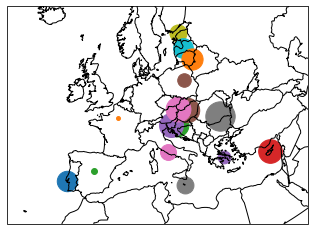

In [465]:
central_lon, central_lat = -5, 55
extent = [-20, 40, 30, 60]

plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))

for i in df_sub_farm.itertuples():
    # print(i.CountryCode)
#     plt.text(i.CapitalLongitude, i.CapitalLatitude, i.CountryCode)
    ax.scatter(
        i.CapitalLongitude, 
        i.CapitalLatitude, 
        s=i.per_farm_subsistence * 1000,
        transform=ccrs.PlateCarree()
    )

ax.set_extent(extent)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)

plt.show()

## What is this map?
- This map shows the count of subsistence farms across europe
- We see that eastern europe has far more subsistence farms than western europe
- Initially hypothesized that this would be true because of a relationship to GDP, but the correlation data suggests this is as good as random
- Many of these states were Warsaw Pact members. They used a system of collective farming
    - Several families of farmers working a large piece of land
    - Poland was one of the few Warsaw Pact nations not to adopt collectiv farming (we can see that clearly in the data)
    - In Romania farms would often have to be forced into collectivization. The practice was abandoned in 1962, which could explain why it is so prevalent today

# Extending the analysis
## Data I would like
- Farm level data
    - Country
    - Output
    - Methods (Conventional, Organic, Regenerative)
    - Products
    - Soil quality
- Better segmentation
- Would be interesting to see how CAP expenditures play into this
    - How well are subsistence farmers represented in the CAP expenditures?

## Considerations
- When you look at the way the current CAP is set up it's a one size fits all policy for Europe
    - Not beneficial to small farmers in developing nations
    - Half of the EU's expenditures are from this bill
    - Does 2 things
        - Support Agricultural Production
        - Rural Development Policy
    - Tends to assist larger farmers more than smaller ones
        - Not sure which needs more support. Should the EU try helping smaller farmers become more efficient (Some research suggests that small farms have higher outputs and healthier soils)
- With farm level data I think one could figure out if subsistence farming is better or worse for the land. Would be curious to know if soil is healthier on small farms, where it is the most important asset to a farmer, or larger farms where they should have access to more information and education (based on the data).